<table>
<tr>
<td width=15%><img src="./img/UGA.png"></img></td>
<td><center><h1>Introduction à la Recherche Opérationelle</h1><br/>M2 Statistique Science des Données (SSD)</center></td>
<td width=15%>
<a href="https://www-ljk.imag.fr/membres/Anatoli.Iouditski/" style="font-size: 16px; font-weight: bold">Anatoli Juditsky</a><br/>
<a href="http://www.iutzeler.org" style="font-size: 16px; font-weight: bold">Franck Iutzeler</a> </td>
</tr>
</table>

<br/><br/>
<center><a style="font-size: 30pt; font-weight: bold">TP 2 - Dantzig Selector </a></center>
<br/><br/>

# 1- Problème de régression parcimonieuse et Dantzig Selector

On considère le modèle de régression normale
$$ y=X\theta+\sigma\xi,\;\;\xi\sim \mathcal{N}(0, I_m),$$
où  $X\in \mathbb{R}^{m\times n}$ et $y\in \mathbb{R}^m$ sont les observables, et $\theta\in \mathbb{R}^n$ est le paramètre inconnu. 


L'estimateur de $\theta$ de *``Dantzig Selector''* (cf. Candes, E., Tao, T. (2007). *The Dantzig selector: Statistical estimation when $p$ is much larger than $n$*. The Annals of Statistics, 2313-2351) peut être utilisé pour estimer $\theta$ dans le cas d'un modèle surparamétré, quand la dimension $n$ de $\theta$ est supérieure a la dimension de l'observation $y$.


Dans ce cas l'estimateur ${\theta}_{DS}$  s'écrit comme une solution du probleme d'optimisation
$\min_{\theta\in  \mathbb{R}^n} \|\theta\|_1,~~~\;\mbox{sous contrainte}\;\|X^T(X\theta-y)\|_\infty\leq \kappa\sigma,$
où $\kappa>0$ est un *hyper-paramètre*. 


La valeur de $\kappa$, préconisée dans la literature, est $c q_{\mathcal{N}}\left(1-{\alpha\over 2m}\right)$, où $\alpha\in (0,1)$ est le niveau de risque choisi (par ex. $\alpha=.05$) et $q_\mathcal{N}(p)$ est la $p$-quantile de la normale standardisée, et $c=\max_j\|[X]_j\|_2=\max_j\sqrt{[X]_j^T[X]_j}$ est la norme maximale de colonne de la matrice $X$.

Votre objectif dans cet exercice sera d'implementer l'estimateur ${\theta}_{DS}$ en utilisant `CVXPY`.

> **Question:** Vérifier que le problème et les contraintes peuvent se formuler via des [fonctions disponibles](https://www.cvxpy.org/examples/index.html) pour CVXPY.

# 2- Un petit exemple

In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd

In [2]:
# Exemple jouet
n = 5
m = 3
sigma = 0.1

X = np.random.randn(m,n)
theta_true = np.array([1,0,0,0,5])
xi = np.random.randn(m)
y = np.dot(X,theta_true) + sigma*xi



In [4]:
X

array([[-2.78926179e+00, -7.90880334e-01,  1.43143980e+00,
        -9.41758591e-01, -1.68768424e+00],
       [-2.12932431e-01,  9.77725851e-01, -6.86749297e-01,
         4.71163516e-02, -2.05882447e-03],
       [ 7.74700258e-01,  7.36947379e-01, -1.29281594e+00,
         1.51532730e+00,  2.97317395e-01]])

In [5]:
y

array([-11.32484117,  -0.64308589,   2.26042816])

In [6]:
theta_true

array([1, 0, 0, 0, 5])

> **Question:** Trouver l'estimateur $\theta_{DS}$ à partir de $X$ et $y$ par résolution du problème d'optimisation via CVXPY avec $\kappa$ fixé à 0.2.

In [16]:
kappa = 0.2
theta = cp.Variable(n)
L = cp.sum(cp.abs(theta))
objective = cp.Minimize(L)
contrainte = cp.norm_inf(X.T@(X@theta - y)) <= kappa*sigma

prob = cp.Problem(objective,[contrainte])
prob.solve()
theta.value

array([ 4.24501885e+00,  2.79005440e-01, -2.31160607e-09, -7.98526304e-01,
        1.48787136e-07])

In [18]:
prob.status

'optimal'

# 3- Fonction "Dantzig Selector"



> **Question:** Écrivez une fonction `DSelect` qui fait appel a `CVXPY` pour calculer l'estimation ${\theta}_{DS}$. 

Cette fonction doit sortir un tuple avec les elements
* `coef`, vecteur des coefficients de regression
* `resid`, vecteur $y-X{\theta}_{DS}$ de résidus
* `status`, le statut de sortie du solver

L'appel à cette fonction devra être:

`DSelect(X, y, sigma = 1, c = 1, verb = False)`

où
* `X` et `y` sont les observables
* `sigma` est une estimation de $\sigma$
* `c` est le paramètre réel tel que la valeur de $\kappa$ dans {DS} est $ \kappa=c\,q_{\mathcal{N}}\left(1-{\alpha\over 2m}\right).$

In [ ]:
import scipy.stats

def DSelect(X, y, sigma = 1, c = 1, verb = False):
    
    m,n = X.shape
    alpha = 0.05
    kappa = c*scipy.stats.norm.ppf(1-alpha/(2*m))

    # Résolution du problème d'optimisation
    theta = cp.Variable(n)
    L = cp.sum(cp.abs(theta))
    objective = cp.Minimize(L)
    contrainte = cp.norm_inf(X.T@(X@theta - y)) <= kappa*sigma
    prob = cp.Problem(objective,[contrainte])
    prob.solve(verbose=verb)
 
    theta_ds = theta.value
    residual = y - X@theta_ds
    sol_status = prob.status
    
    return theta_ds,residual,sol_status

In [20]:
DSelect(X, y, sigma, c=1, verb=True)

(CVXPY) Oct 02 11:01:53 AM: Your problem has 5 variables, 1 constraints, and 0 parameters.
(CVXPY) Oct 02 11:01:53 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 02 11:01:53 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 02 11:01:53 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 02 11:01:53 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Oct 02 11:01:53 AM: Compiling problem (target solver=CLARABEL).
(CVXPY) Oct 02 11:01:53 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CLARABEL
(CVXPY) Oct 02 11:01:53 AM: Applying reduction Dcp2Cone
(CVXPY) Oct 02 11:01:53 AM: Applying reduction CvxAttr2Constr
(CVXPY) Oct 02 11:01:53 AM: Applying reduction ConeMatrixStuffing
(CVXPY) Oct 02 11:01:53 AM: Applying reduction CLARABEL
(CVXPY) Oct 02 11:01:53 AM: Finished problem compilatio

                                     CVXPY                                     
                                     v1.7.3                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-------------------------------------------------------------
           Clarabel.rs v0.11.1  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 11
  constraints 

(CVXPY) Oct 02 11:01:53 AM: Problem status: optimal
(CVXPY) Oct 02 11:01:53 AM: Optimal value: 4.585e+00
(CVXPY) Oct 02 11:01:53 AM: Compilation took 1.242e-02 seconds
(CVXPY) Oct 02 11:01:53 AM: Solver (including time spent in interface) took 5.061e-03 seconds


  0  +0.0000e+00  -2.3940e-01  2.39e-01  3.99e-01  6.89e-01  1.00e+00  4.09e+00   ------   
  1  +4.0883e+00  +4.2194e+00  3.21e-02  1.43e-01  2.27e-01  4.92e-01  1.65e+00  6.85e-01  
  2  +3.9520e+00  +3.9947e+00  1.08e-02  2.59e-02  3.37e-02  1.04e-01  3.67e-01  8.56e-01  
  3  +4.3811e+00  +4.4271e+00  1.05e-02  1.77e-02  2.04e-02  8.76e-02  2.09e-01  5.55e-01  
  4  +4.5261e+00  +4.5314e+00  1.16e-03  2.74e-03  3.34e-03  1.18e-02  4.03e-02  9.76e-01  
  5  +4.5741e+00  +4.5747e+00  1.32e-04  3.84e-04  4.76e-04  1.52e-03  5.95e-03  8.58e-01  
  6  +4.5851e+00  +4.5851e+00  5.12e-06  1.53e-05  1.90e-05  6.01e-05  2.41e-04  9.82e-01  
  7  +4.5854e+00  +4.5854e+00  5.12e-08  1.53e-07  1.90e-07  6.02e-07  2.41e-06  9.90e-01  
  8  +4.5854e+00  +4.5854e+00  5.12e-10  1.53e-09  1.90e-09  6.02e-09  2.41e-08  9.90e-01  
---------------------------------------------------------------------------------------------
Terminated with status = Solved
solve time = 255.6µs
-------------------------

(array([ 4.14354943e+00, -7.07329727e-09,  7.90894999e-09, -4.41808375e-01,
         1.29174854e-08]),
 array([-0.18347392,  0.26002658, -0.28009635]),
 'optimal')

##  Test quand on connait le *vrai* theta

In [36]:
n = 5
m = 5
X = np.random.randn(m,n)
theta_true = np.random.randn(n)
sigma = 0.005

y = np.dot(X,theta_true) + sigma*np.random.randn(m)

Avec la valeur de sigma prise ci-dessus, vous devriez pouvoir appeler votre fonctions comme ci-dessous. 

In [37]:
f = DSelect(X, y, sigma=sigma)

> **Question:** Testez votre fonction sur cet exemple jouet. En particulier, comparez la valeur de `theta_ds` à la vraie valeur `theta_true`.

In [38]:
# theta_ds
print(f[0])
# theta_true
print(theta_true)
# Distance
sum(abs(f[0]-theta_true))

[ 8.50109643e-01 -1.38013813e+00  2.36737472e-11  8.37871448e-02
 -1.33656805e+00]
[ 1.14829783 -1.27116619 -1.61778598 -0.08424462 -1.34668223]


np.float64(2.2030920574803026)

## Example du papier de Candes/Tao

In [57]:
import random

n = 256
m = 72
S = 1 # Originaly 8

S_set = random.sample(range(n),k=S)

X = np.random.randn(m,n)

theta_true = np.zeros(n)
theta_true[S_set] = np.random.randn(S)

sigma = 1/3.0*np.sqrt(S/m)
y = np.dot(X,theta_true) + sigma*np.random.randn(m)

In [58]:
f = DSelect(X, y, sigma= sigma)

> **Question:** Testez votre fonction sur l'exemple du papier. Comparez la valeur de `theta_ds` à la vraie valeur `theta_true`. Essayer de changer `sigma`.

In [59]:
# theta_ds
print(f[0])
# theta_true
print(theta_true)
# Distance
sum(abs(f[0]-theta_true))

[ 3.77686713e-03  5.98371386e-13 -2.01979336e-12  5.13325758e-12
  4.31147077e-12  4.35147880e-03 -7.21127114e-12 -1.15298317e-12
 -4.49443693e-12  3.19710945e-12  2.73450934e-12  6.80147369e-13
  1.98610724e-12  1.26484098e-11  2.09651131e-12  4.31157600e-12
  2.99149530e-12 -6.48765870e-13 -5.05499917e-13  3.42774982e-12
 -6.82806889e-12 -3.55625596e-12  6.01509939e-12  7.80006179e-13
 -4.26566658e-11  2.65825964e-03 -3.83531173e-12 -1.25435068e-12
 -5.03579547e-12  2.04214237e-03  2.34719540e-11  2.24362622e-12
 -1.52563550e-11 -9.47613598e-03 -5.46486544e-12 -6.17579047e-13
 -4.64676457e-11 -3.47306984e-03  7.71729268e-14 -3.33376601e-11
  5.50516752e-13 -3.91448869e-12 -9.52007853e-04 -4.50083202e-04
  5.36742358e-04  5.37884556e-12  5.47109172e-12  7.14034545e-11
 -7.08593560e-03  7.95897697e-12 -7.77877916e-11 -1.34517222e-12
  1.48814322e-03  2.82757269e-14 -9.24669527e-13  1.11357947e-12
 -3.12149361e-12  4.90658142e-12  1.32945319e-12 -1.73956305e-12
  8.06347767e-03 -3.39659

np.float64(0.158372841121356)

Il semble que plus sigma est petit, plus |`theta_ds - theta_true`| est petit. Car les résidus sont contraints par sigma, y est + proche de X.

### Support des solutions

La valeur cherchée `theta_true` est très parcimonieuse (elle contient beaucoup de zéros). Les seules valeurs non-null sont aux positions suivantes.

In [60]:
S_set

[74]

In [61]:
theta_true

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.11428

> **Question:** Comparez le nombre et l'emplacement des zéros dans `theta_ds` à ceux dans `theta_true`. Essayez de changer `c`.

In [62]:
print(len(S_set)) # Nombre de zeros dans theta_true
print(len(f[0][f[0]==0]))  # Nombre de zeros dans theta_ds

1
0


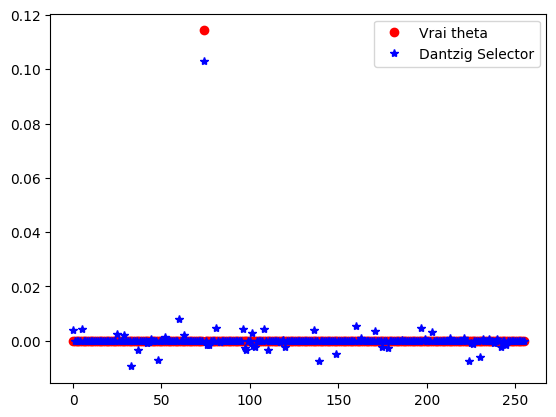

In [63]:
import matplotlib.pyplot as plt

plt.plot(theta_true,'ro',label='Vrai theta')
plt.plot(f[0],'b*',label='Dantzig Selector')
plt.legend();